# Instrument Control Outline

## Key Elements 

1. __Static Metadata or InstrumentSheet:__ Information about instruments that do not change or change on a long time scale.
    + Instrument Location
    + Instrument GPIB Address
    + Commands that define the most common instrument state
    + The Instrument Make and Model
    + The Manufacturer of the Instrument
    + The location of the Instrument Manual
    
   Example of an XML based Instrument Sheet
    
2. __Dynamic Metadata or InstrumentState:__ The State of the instrument at the time of data collection.
    + Any set of commands that was set before the measurement. Currently supports unordered commands, but I intend to add ordered commands.
    
    Example of an XML based state

3. __VisaInstrument:__ A general class for instrument control. 
    + This class works identically to exisiting visa classes with additions. For example pna=VisaInstrument("GPIB::16") will open a visa session with the instrument at address 16. To write to the instrument pna.write("SENS:BAND 10") to query use pna.query("SENS:BAND?").
    + If there is a Static Metadata sheet in a specified directory it will automatically look it up and add the information to the class. It also allows calling the instrument by any unique fact for example if there is only one E8631A instrument you can call it like pna=VisaInstrument("E8631A"), pna=VisaInstrument("Keysight_E8361A_4639_001"), etc.
    + States can be interogated saved and recalled. The instrument has the get_state() method that returns the state specified by the Static metadata. Other states can be interogated by passing a set/query dictionary.
    + The current state can be saved by using save_current_state method.
    + A saved state can be reloaded to the instrument by the load_state("MyState.xml") method.

4. __Specific Instruments:__For more complex instruments like a vna, we can inherit from this class. The specific instrument will have all the same methods and attributes.  
    + Should have an initialize method to put the instrument in the most common state
    + Methods that measure something and return the value should be named measure_something()
    + Common configuration commands should have set/get structure
    + The class should inherit from VisaInstrument
    ```python 
    class VNA(VisaInstrument):
        pass
    ```

    

1. The unique naming of instruments
2. Definition of an InstrumentSheet
3. Inherit from VisaInstrument
4. The behavior of the method initialize()
5. Configuration Settings (set/get)
6. Measurement (measure)

## Naming of Instruments

Manufacturer_Model_RoomNumber_Iterator<br/>
ex:<br/>
RS_ZVA110_4639_001<br/>
Keysight_E8361A_4639_001

## Defining an InstrumentSheet


## Inherit from VisaInstrument class
```python
class E8361A(VisaInstrument):
    pass
```

This gives the methods
+ set_state
+ get_state
+ load_state
+ read
+ write 
+ ask and query (same command)

and automatically populates any static metadata fields from the InstrumentSheet


## All specific instruments should have an intialize method
```python
vna=E8631("Keysight_E361A_4639_001")
vna.initialize()
```

## Configuration Commands
Commands that change the state fo the instrument but do not take a measurement should be named set_configuration and ones that read it should be get_configuration. These commands should take either numeric types or strings, the units should be specified in the doc string of the method.

```python
vna.set_IFBW(10)
vna.get_IFBW()
vna.set_power('0')
```

## Measurement Commands
Commands that take a measurement and return something should be named using measure_typeofmeasurement. These methods can return a class from the DataHandlers subpackage or a native python type. If keyword options are used then they should "pass through".
```python
sparameters=vna.measure_sparameters()
new_power_reading=power_meter.measure_power()
```

In [1]:
from pyMeasure import *

Importing pyMeasure, this should take roughly 30 seconds
The module smithplot was not found,please put it on the python path
The module smithplot was not found,please put it on the python path


In [2]:
import time

In [21]:
class VNA(VisaInstrument):
    """Control class for a linear VNA """
    def __init__(self,resource_name=None,**options):
        """Initializes the E8631A control class"""
        defaults={"state_directory":os.getcwd()}
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        VisaInstrument.__init__(self,resource_name,**self.options)
        self.power=self.get_power()
        self.IFBW=self.get_IFBW()
        #this should be if SENS:SWE:TYPE? is LIN or LOG
        start=float(self.query("SENS:FREQ:START?").replace("\n",""))
        stop=float(self.query("SENS:FREQ:STOP?").replace("\n",""))
        number_points=int(self.query("SENS:SWE:POIN?").replace("\n",""))
        self.frequency_list=np.linspace(start,stop,number_points).tolist()

    def initialize(self):
        """Intializes the system"""
        self.write("SYST:FPRESET")
        self.write("DISPlay:WINDow1:STATE ON")
        self.write("CALCulate:PARameter:DEFine 'S11',S11")
        self.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")
        self.write("CALCulate:PARameter:DEFine 'S12',S12")
        self.write("DISPlay:WINDow1:TRACe2:FEED 'S12'")
        self.write("CALCulate:PARameter:DEFine 'S21',S21")
        self.write("DISPlay:WINDow1:TRACe3:FEED 'S21'")
        self.write("CALCulate:PARameter:DEFine 'S22',S22")
        self.write("DISPlay:WINDow1:TRACe4:FEED 'S22'")
        start=float(self.query("SENS:FREQ:START?").replace("\n",""))
        stop=float(self.query("SENS:FREQ:STOP?").replace("\n",""))
        number_points=int(self.query("SENS:SWE:POIN?").replace("\n",""))
        self.frequency_list=np.linspace(start,stop,number_points).tolist()
    
    def enable_correction(self):
        """Enables the Sparameter Correction"""
        self.write("SENS:CORR:STAT 1")
        
    def disable_correction(self):
        "Disables the Sparameter Correction"
        self.write("SENS:CORR:STAT 0")
        
    def set_power(self,power):
        """Sets the power of the Instrument in dbm"""
        self.write('SOUR:POW {0}'.format(power))
        
    def get_power(self):
        "Returns the power of the instrument in dbm"
        return self.query('SOUR:POW?')
    
    def set_IFBW(self,ifbw):
        """Sets the IF Bandwidth of the instrument in Hz"""
        self.write('SENS:BAND {0}'.format(ifbw))
        self.IFBW=ifbw
        
    def get_IFBW(self):
        """Returns the IFBW of the instrument in Hz"""
        ifbw=float(self.query('SENS:BAND?'))
        self.IFBW=ifbw
        return ifbw
    
    def set_frequency(self,start,stop=None,number_points=None,step=None,units='Hz'):
        """Sets the VNA to a linear mode and creates a single entry in the frequency table. If start is the only specified
        parameter sets the entry to start=stop and number_points = 1. If step is specified calculates the number of points 
        and sets start, stop, number_points on the VNA. It also stores the value into the attribute frequency_list. 
        """
        if stop is None and number_points is None:
            stop=start
            number_points=1
        if number_points is None and not step is None:
            number_points = round((stop-start)/step) + 1
        self.frequency_list=np.linspace(start,stop,number_points).tolist()
        self.write('SWE:TYPE LIN')
        self.write("SENS:FREQ:START {0}".format(start))
        self.write("SENS:FREQ:STOP {0}".format(stop))
        self.write("SENS:SWE:POIN {0}".format(number_points))
        
    def get_frequency(self):
        "Returns the frequency in python list format"
        return self.frequency_list
    
    def is_busy(self):
        """Checks if the instrument is currently doing something and returns a boolean value"""
        opc=bool(self.resource.query("*OPC?"))
        return not opc
    
    def measure_switch_terms(self,**options):
        """Measures switch terms and returns a s2p table in foward and reverse format"""
        defaults={}
        self.measure_switch_term_options={}
        for key,value in defaults.iteritems():
            self.measure_switch_term_options[key]=value
        for key,value in options:
            self.measure_switch_term_options[key]=value
        # this resets the traces to be based on swith terms
        # Set VS to be remotely triggered by GPIB
        self.write("SENS:HOLD: FUNC HOLD")
        self.write("TRIG:REM:TYP CHAN")
        # Set the Channel to have 2 Traces
        self.write("CALC1:PAR:COUN 2")
        # Trace 1 This is port 2 or Forward Switch Terms 
        self.write("CALC:PAR:DEF 'FWD',A2B2,1")
        
        # Trace 2 This is port 1 or Reverse Switch Terms 
        self.write("CALC:PAR:DEF 'REV',A1B1,2")
        
        # Select Channel
        self.write("CALC1:SEL;")
        self.write("ABORT;TRIG:SING;")
        # Sleep for the duration of the scan
        time.sleep(len(self.frequency_list)*2/float(self.IFBW))
        # wait for other functions to be completed
        while self.is_busy():
            time.sleep(.01)
        # Set the read format
        self.write("FORM:DATA ASC")
        # Read in the data
        self.write("CALC:PAR:SEL FWD;")
        foward_switch_string=self.query("CALC:DATA? SDATA")
        while self.is_busy():
            time.sleep(.01)
        self.write("CALC:PAR:SEL REV;")
        reverse_switch_string=self.query("CALC:DATA? SDATA")
        # Now parse the string
        foward_switch_list=foward_switch_string.replace("\n","").split(",")
        reverse_switch_list=reverse_switch_string.replace("\n","").split(",")
        real_foward=foward_switch_list[0::2]
        imaginary_forward=foward_switch_list[1::2]
        real_reverse=reverse_switch_list[0::2]
        imaginary_reverse=reverse_switch_list[1::2]
        switch_data=[]
        for index,frequency in enumerate(self.frequency_list[:]):
            new_row=[frequency,
                     real_foward[index],imaginary_forward[index],
                     real_reverse[index],imaginary_reverse[index],
                     0,0,
                     0,0]
            switch_data.append(new_row)
        option_line="# Hz S RI R 50"
        # add some options here about auto saving 
        # do we want comment options?
        s2p=S2PV1(None,option_line=option_line,data=switch_data)
        return s2p
        
    def measure_sparameters(self,**options):
        """Triggers a single sparameter measurement for all 4 parameters and returns a SP2V1 object"""
        defaults={"trigger":"single"}
        self.measure_sparameter_options={}
        for key,value in defaults.iteritems():
            self.measure_sparameter_options[key]=value
        for key,value in options:
            self.measure_sparameter_options[key]=value
        if self.measure_sparameter_options["trigger"] in ["single"]:
            self.write("INITiate:CONTinuous OFF")
            self.write("ABORT;INITiate:IMMediate;*wai")
            # now go to sleep for the time to take the scan
            time.sleep(len(self.frequency_list)*2/float(self.IFBW))
            
        # wait for other functions to be completed
        while self.is_busy():
            time.sleep(.01)
        # Set the format to ascii and set up sweep definitions
        self.write('FORM:ASCII')
        # First get the Sparameter lists
        self.write('CALC:PAR:SEL S11')
        self.write('CALC:FORM MLIN')
        while self.is_busy():
            time.sleep(.01)
        s11_string=self.query('CALC:DATA? SDATA')
        
        self.write('CALC:PAR:SEL S12')
        self.write('CALC:FORM MLIN')
        while self.is_busy():
            time.sleep(.01)
        s12_string=self.query('CALC:DATA? SDATA')
        self.write('CALC:PAR:SEL S21')
        self.write('CALC:FORM MLIN')
        while self.is_busy():
            time.sleep(.01)
        s21_string=self.query('CALC:DATA? SDATA')
        self.write('CALC:PAR:SEL S22')
        self.write('CALC:FORM MLIN')
        while self.is_busy():
            time.sleep(.01)
        s22_string=self.query('CALC:DATA? SDATA')
        # String Parsing
        s11_list=s11_string.replace("\n","").split(",")
        s12_list=s12_string.replace("\n","").split(",")
        s21_list=s21_string.replace("\n","").split(",")
        s22_list=s22_string.replace("\n","").split(",")
        # Construct a list of lists that is data in RI format
        reS11=s11_list[0::2]
        imS11=s11_list[1::2]
        reS12=s12_list[0::2]
        imS12=s12_list[1::2]
        reS21=s21_list[0::2]
        imS21=s21_list[1::2]
        reS22=s22_list[0::2]
        imS22=s22_list[1::2]
        sparameter_data=[]
        for index,frequency in enumerate(self.frequency_list[:]):
            new_row=[frequency,
                     reS11[index],imS11[index],
                     reS21[index],imS21[index],
                     reS12[index],imS12[index],
                     reS22[index],imS22[index]]
            sparameter_data.append(new_row)
        option_line="# Hz S RI R 50"
        # add some options here about auto saving 
        # do we want comment options?
        s2p=S2PV1(None,option_line=option_line,data=sparameter_data)
        return s2p
        
            

In [22]:
pna=VNA("E83")

In [23]:
#s2p=pna.measureSparameters()

pna.initialize()
s2p=pna.measureSparameters()
switch=pna.measure_switch_terms()

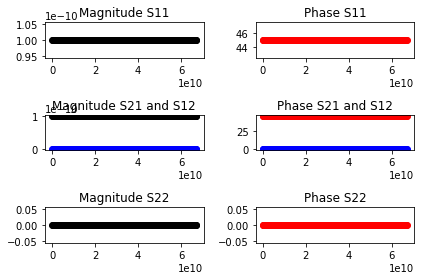

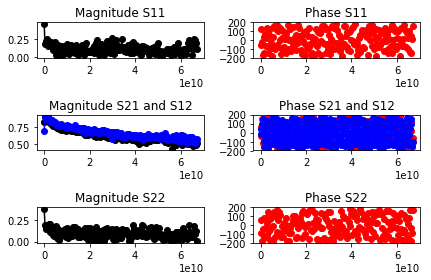

In [24]:
switch.show();
s2p.show();

In [10]:
pna.ask("CALC:PAR:CAT?")

u'"S11,S11,S12,S12,S21,S21,S22,S22,FWD,a2/b2,1,REV,a1/b1,2"\n'

In [29]:
pna.write("SENS:HOLD: FUNC HOLD")
pna.write("TRIG:REM:TYP CHAN")

(19L, <StatusCode.success: 0>)

In [60]:
pna.write("CALC:PAR2:DEF 'REV',A1B1,2")

(28L, <StatusCode.success: 0>)

In [ ]:
pna.

In [35]:
# Set the Channel to have 2 Traces
pna.write("CALC1:PAR:COUN 2")
# Trace 1 This is port 2 or Forward Switch Terms 
pna.write("CALC1:PAR1:DEF 'FWD',A2B2,1")

(29L, <StatusCode.success: 0>)

In [ ]:


self.write("CALC:PAR1:FORM REIM")
# Trace 2 This is port 1 or Reverse Switch Terms 
self.write("CALC:PAR2:DEF:EXT REV A1/B1,2")
self.write("CALC:PAR2:FORM REIM")
# Select Channel
self.write("CALC1:SEL;")
self.write("ABORT;TRIG:SING;")
# Sleep for the duration of the scan
time.sleep(len(self.frequency_list)*2/float(self.IFBW))
# wait for other functions to be completed
while self.is_busy():
    time.sleep(.01)
# Set the read format
self.write("FORM:DATA ASC")
# Read in the data
self.write("CALC:PAR:SEL FWD")
foward_switch_string=self.query("CALC:DATA? SDATA")
self.write("CALC:PAR:SEL REV")
reverse_switch_string=self.query("CALC:DATA? SDATA")
# Now parse the string
foward_switch_list=foward_switch_string.replace("\n","").split(",")
reverse_switch_list=reverse_switch_string.replace("\n","").split(",")
real_foward=foward_switch_list[0::2]
imaginary_forward=foward_switch_list[1::2]
real_reverse=reverse_switch_list[0::2]
imaginary_reverse=reverse_switch_list[1::2]
switch_data=[]
for index,frequency in enumerate(self.frequency_list[:]):
    new_row=[frequency,
             real_foward[index],imaginary_forward[index],
             real_reverse[index],imaginary_reverse[index],
             0,0,
             0,0]
    switch_data.append(new_row)
option_line="# Hz S RI R 50"
# add some options here about auto saving 
# do we want comment options?
s2p=S2PV1(None,option_line=option_line,data=switch_data)


In [78]:
from IPython.display import HTML
instrument_sheet_path=find_description("ZVA")
description=InstrumentSheet(instrument_sheet_path)
html=description.to_HTML("DEFAULT_INSTRUMENT_STYLE.xsl")
HTML(html)

Name :,ZVA110
Alias :,RS_ZVA110_4639_01
Location :,"Building 1, 4639"
Price :,"$360,000"
Serial :,1312700403101122
IDN :,"Rohde&Schwarz,ZVA67-4Port,1312700403101122,3.80"
Instrument_Type :,GPIB
Instrument_Address :,GPIB::20
Purchase_Date :,08/2014
NIST_Tag :,938506
Command :,This is the command sent over the GPIB bus.


In [5]:
vna=VNA("ZVA110")

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [88]:
s2p.options

{'column_descriptions': None,
 'column_names_delimiter': None,
 'column_units': None,
 'comments': [['My Comment', 0, 0]],
 'data': [[10000000.0,
   0.2445986,
   -0.4011899,
   0.661909,
   -0.4624518,
   0.6742942,
   -0.1143902,
   0.0256612,
   -0.3901316],
  [344950000.0,
   -0.1054258,
   0.1461881,
   0.436736,
   0.7742531,
   0.7327377,
   0.533442,
   0.1150192,
   0.1592259],
  [679900000.0,
   0.2094475,
   -0.06094664,
   -0.7635906,
   0.4052979,
   -0.04246189,
   0.8999793,
   -0.1556547,
   -0.02422561],
  [1014850000.0,
   -0.1890512,
   -0.03827717,
   -0.391169,
   -0.7633702,
   -0.7622647,
   0.4280263,
   0.1150289,
   -0.09089366],
  [1349800000.0,
   0.1968578,
   0.1535921,
   0.7498753,
   -0.3682343,
   -0.8080691,
   -0.3808108,
   0.03282444,
   0.1597827],
  [1684750000.0,
   -0.113907,
   -0.09294597,
   0.3846999,
   0.7739364,
   -0.09857258,
   -0.9023687,
   -0.1268557,
   -0.08136833],
  [2019700000.0,
   0.07933894,
   0.1863788,
   -0.7533855,
   

In [64]:
vna.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'10000',
 'SENS:CORR:STAT': u'1',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-10',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'0'}

In [60]:
vna.set_frequency(3*10**8,50*10**9,1000)
print vna.query("*OPC?")
s2p=vna.measure_sparameters()

1



In [62]:
vna.resource_manager.close()

In [133]:
s2p.change_frequency_units("GHz")
s2p.change_data_format("RI")

In [134]:
print s2p

# GHz S RI R 50
0.01  1.202  -0.275  -0.000646  0.0002206  0.0002091  -0.0005692  0.3152  -0.6769
0.345  -0.7546  0.5605  -2.145e-06  8.914e-06  -8.751e-07  -1.778e-05  0.7707  -0.3937
0.6799  0.5259  -0.7619  1.773e-06  9.839e-07  3.134e-08  -4.84e-06  0.8207  -0.2467
1.015  -0.2701  0.8583  -1.464e-06  3.41e-06  1.238e-06  7.112e-06  0.7753  -0.178
1.35  -0.1142  -0.9036  -1.744e-06  -7.52e-06  -1.256e-06  3.845e-06  0.809  -0.1248
1.685  0.417  0.9095  4.476e-06  -3.479e-07  4.17e-06  -4.976e-06  0.7723  0.0857
2.02  -0.6137  -0.7702  -2.824e-06  4.985e-06  9.882e-06  8.411e-07  0.8049  0.02751
2.355  0.7654  0.4085  -4.326e-06  -9.09e-06  8.578e-06  -8.719e-06  0.774  0.2788
2.69  -0.9692  -0.1269  -1.215e-05  5.203e-06  -1.563e-05  -2.606e-06  0.656  0.3802
3.025  0.948  -0.1208  -1.249e-05  6.977e-06  1.233e-07  -5.719e-06  0.619  0.3754
3.36  -0.8244  0.5959  1.621e-07  1.637e-06  -8.614e-06  3.403e-06  0.6088  0.4972
3.694  0.7387  -0.6237  6.102e-06  7.623e-06  1.436e-06  -3.8

In [135]:
s2p.path

'Two_Port_Sparameter_20170425_001.s2p'

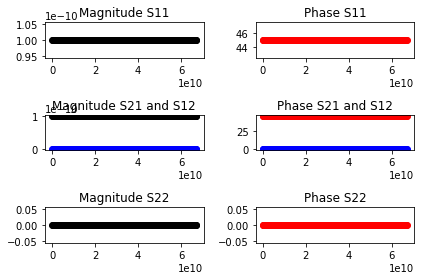

In [59]:
switch.show();

In [69]:
from pyMeasure.Code.Analysis.SParameter import *

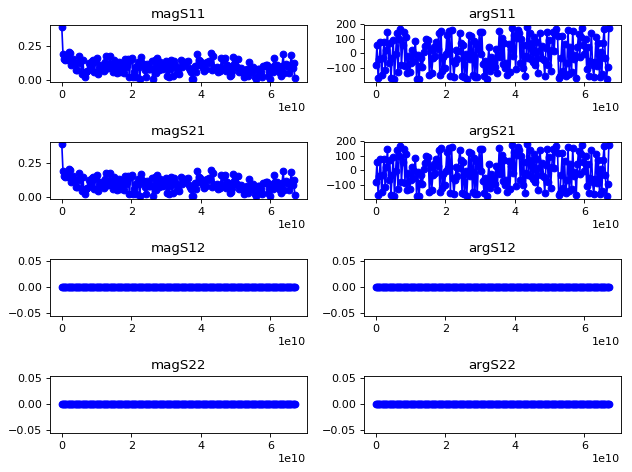

In [56]:
plot_frequency_model(switch);

In [74]:
vna.resource_manager.close()

VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a failed network connection, or a lower-level driver or OS error.

In [62]:
pna=VisaInstrument("E8361A")

In [63]:
pna.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'+1.00000000000E+001',
 'SENS:CORR:STAT': u'0',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-1.70000000000E+001',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'+0.00000000000E+000'}

In [171]:
pna.close()

VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a failed network connection, or a lower-level driver or OS error.

In [6]:
pna.idn

'Agilent Technologies,E8361A,US43140754,A.07.50.67'

In [16]:
pna=VNA("E8361A")

In [3]:
pna.initialize()

In [4]:
len(pna.frequency_list)

201

In [141]:
pna.set_IFBW(2000)

In [86]:
while pna.is_busy():
    time.sleep(.1)

In [5]:

#pna.set_frequency(10**6,40*10**9,201)
s2p=pna.measure_sparameters()

In [18]:
switch=pna.measure_switch_terms()

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

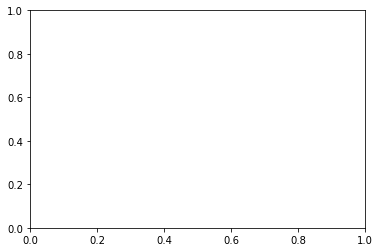

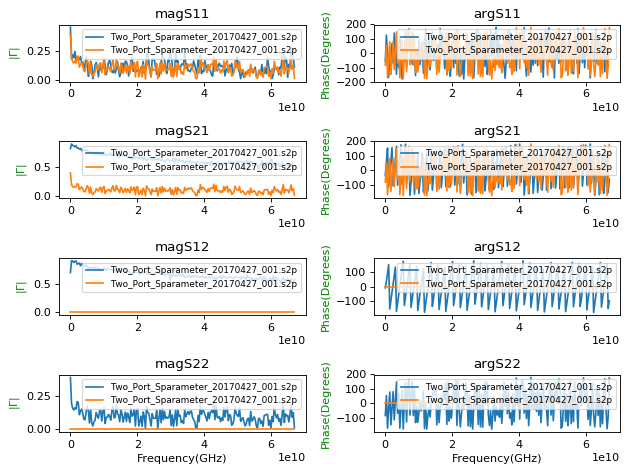

In [55]:
compare_s2p_plots([s2p,switch]);

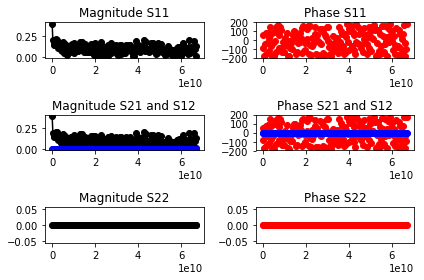

In [54]:
switch.show();

In [161]:
#pna.write(":PAR1:FORM REIM")
pna.write("CALC:FORM MLIN")
test_list=pna.ask("CALC1:DATA? SDATA")

In [162]:
test_list=test_list.replace("\n","").split(",")

In [163]:
print test_list

[u'+3.08159300000E-001', u'-6.56623400000E-001', u'+7.71123700000E-001', u'-3.93523000000E-001', u'+8.21583200000E-001', u'-2.46707600000E-001', u'+7.66312300000E-001', u'-1.85351300000E-001', u'+8.03977900000E-001', u'-1.34515400000E-001', u'+7.63679600000E-001', u'+6.78140100000E-002', u'+7.88053900000E-001', u'+8.59997400000E-003', u'+7.63611600000E-001', u'+2.57543900000E-001', u'+6.49658900000E-001', u'+3.57339400000E-001', u'+6.18765500000E-001', u'+3.75428100000E-001', u'+5.98719300000E-001', u'+4.51824300000E-001', u'+4.95976900000E-001', u'+5.88809600000E-001', u'+4.05853500000E-001', u'+5.73843700000E-001', u'+2.69542300000E-001', u'+6.83235100000E-001', u'+1.10018900000E-001', u'+6.01261100000E-001', u'+1.43913400000E-001', u'+7.10863800000E-001', u'-1.02486000000E-001', u'+6.63077900000E-001', u'-1.27118900000E-001', u'+5.97547100000E-001', u'-2.40805000000E-001', u'+5.70767800000E-001', u'-3.43108800000E-001', u'+5.04866700000E-001', u'-4.18284100000E-001', u'+4.9646340000

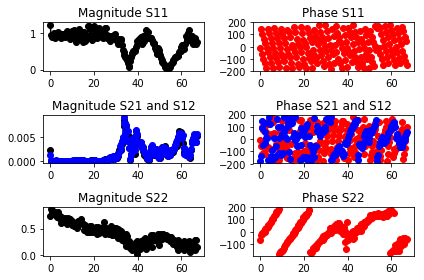

In [143]:
s2p.change_frequency_units("GHz")
s2p.show();

In [11]:
pna.write("SYST:FPRESET")
pna.write("DISPlay:WINDow1:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S11',S11")
pna.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")

(35L, <StatusCode.success: 0>)

In [12]:
pna.write("CALCulate:PARameter:DEFine 'S21',S21")
pna.write("DISPlay:WINDow1:TRACe2:FEED 'S21'")

(35L, <StatusCode.success: 0>)

In [8]:
pna.write("DISPlay:WINDow3:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S12',S12")
pna.write("DISPlay:WINDow3:TRACe3:FEED 'S12'")

(35L, <StatusCode.success: 0>)

In [9]:
pna.write("DISPlay:WINDow4:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S22',S22")
pna.write("DISPlay:WINDow4:TRACe4:FEED 'S22'")

(35L, <StatusCode.success: 0>)

In [15]:
pna.write("SYST:FPRESET")
pna.write("DISPlay:WINDow1:STATE ON")
pna.write("CALCulate:PARameter:DEFine 'S11',S11")
pna.write("DISPlay:WINDow1:TRACe1:FEED 'S11'")
pna.write("CALCulate:PARameter:DEFine 'S12',S12")
pna.write("DISPlay:WINDow1:TRACe2:FEED 'S12'")
pna.write("CALCulate:PARameter:DEFine 'S21',S21")
pna.write("DISPlay:WINDow1:TRACe3:FEED 'S21'")
pna.write("CALCulate:PARameter:DEFine 'S22',S22")
pna.write("DISPlay:WINDow1:TRACe4:FEED 'S22'")

(35L, <StatusCode.success: 0>)

In [21]:
pna.write("SENS:SWE:MODE HOLD")
#pna.write("TRIG:SOUR MAN")
#pna.write("CONT:SIGN BNC,TILHIGH")
#pna.write('TRIG:SCOP ALL')
pna.write("SENS1:SWE:MODE GROUPS")

(23L, <StatusCode.success: 0>)

In [20]:
pna.write("SENS:SWE:MODE HOLD")
pna.write("TRIG:SOUR MAN")
pna.write("CONT:SIGN BNC,TILHIGH")

(23L, <StatusCode.success: 0>)

```vb
Private Sub ReadWrite_Click()
Dim i As Integer
Dim t As Integer
Dim q As Integer
Dim dat As String
Dim cmd As String
Dim datum() As Double
GPIB.Configure
GPIB.Write "SYSTem:PRESet;*wai"
'Select the measurement
GPIB.Write "CALCulate:PARameter:SELect 'CH1_S11_1'"
'Read the number of data points
GPIB.Write "SENSe1:SWEep:POIN?"
numpts = GPIB.Read
'Turn continuous sweep off
GPIB.Write "INITiate:CONTinuous OFF"
'Take a sweep
GPIB.Write "INITiate:IMMediate;*wai"
'Ask for the Data
'PICK ONE OF THESE LOCATIONS TO READ
'GPIB.Write "CALCulate:DATA? FDATA" 'Formatted Meas
'GPIB.Write "CALCulate:DATA? FMEM" 'Formatted Memory
GPIB.Write "CALCulate:DATA? SDATA" 'Corrected, Complex Meas
'GPIB.Write "CALCulate:DATA? SMEM" 'Corrected, Complex Memory
'GPIB.Write "CALCulate:DATA? SCORR1" 'Error-Term Directivity
'Number of values returned per data point
```

In [23]:
data=pna.query('CALC:DATA? SDATA')

In [112]:
pna.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'+5.00000000000E+001',
 'SENS:CORR:STAT': u'0',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-1.70000000000E+001',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'+0.00000000000E+000'}

In [24]:
len(data)

8040

In [26]:
len(data.split(','))

402

In [28]:
pna.ask('SENS:SWE:POIN?')

u'+201\n'

In [32]:
s11_string=pna.query('CALC:DATA? SDATA')
pna.write('CALC:PAR:SEL S12')
s12_string=pna.query('CALC:DATA? SDATA')

In [35]:
len(s11_string.split(','))

402

In [36]:
dir(pna)

['DEFAULT_STATE_QUERY_DICTIONARY',
 'STATE_BUFFER_MAX_LENGTH',
 '__doc__',
 '__init__',
 '__module__',
 '__str__',
 'addEntry',
 'add_entry',
 'alias',
 'ask',
 'commands',
 'current_state',
 'description',
 'document',
 'getImagePath',
 'getQueryDictionary',
 'getState',
 'get_image_path',
 'get_query_dictionary',
 'get_state',
 'idn',
 'image',
 'info_found',
 'info_path',
 'instrument_address',
 'instrument_type',
 'loadState',
 'load_state',
 'location',
 'name',
 'nist_tag',
 'options',
 'path',
 'query',
 'read',
 'resource',
 'resource_manager',
 'root',
 'save',
 'saveCurrentState',
 'saveHtml',
 'saveState',
 'save_HTML',
 'save_current_state',
 'save_state',
 'setState',
 'set_state',
 'show',
 'state_buffer',
 'toHtml',
 'to_HTML',
 'updateCurrentState',
 'update_current_state',
 'write']

In [37]:
pna.location

'Building 81, D121'

In [38]:
pna.name

'E8361A'

In [39]:
pna.commands

[]

In [12]:
zva=VisaInstrument("ZVA110")

VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

In [42]:
pna.resource_manager.close()

VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a failed network connection, or a lower-level driver or OS error.

In [4]:
zva.idn

'Rohde&Schwarz,ZVA67-4Port,1312700403101122,3.80'

In [7]:
zva_2=VNA("ZVA")

In [8]:
zva_2.initialize()

In [9]:
zva.get_state()

{'SENS:AVER': u'0',
 'SENS:BAND': u'10000',
 'SENS:CORR:STAT': u'1',
 'SENS:SWE:TYPE': u'LIN',
 'SOUR:POW': u'-10',
 'SOUR:POW:CORR:STAT': u'0',
 'SOUR:POW:SLOP': u'0'}

In [11]:
zva.save_current_state()

In [135]:
class InstrumentState(XMLBase):
    """ An instrument state is an XML file with instrument setting information"""
    def __init__(self,file_path=None,**options):
        """ Intialize the InstrumentState class"""
        defaults={"root":"Instrument_State",
                  "style_sheet":os.path.join(XSLT_REPOSITORY,
                                             'DEFAULT_STATE_STYLE.xsl').replace('\\','/'),
                  "specific_descriptor":'Instrument',
                  "general_descriptor":'State',
                  "directory":None,
                  "extension":'xml',
                  "date":"now",
                  "state_dictionary":None,
                  "state_table":None
                  }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value


        XMLBase.__init__(self,file_path,**self.options)
        self.state_node=self.document.createElement('State')
        self.document.documentElement.appendChild(self.state_node)

            
            
        if self.options["state_dictionary"]:
            for key,value in self.options["state_dictionary"].iteritems():
                new_entry=self.document.createElement('Tuple')
                set_attribute=self.document.createAttribute('Set')
                value_attribute=self.document.createAttribute('Value')
                new_entry.setAttributeNode(set_attribute)
                new_entry.setAttributeNode(value_attribute)
                new_entry.setAttribute('Set',key)
                new_entry.setAttribute('Value',str(value))
                self.state_node.appendChild(new_entry)
        if self.options["state_table"]:
            if "Index" in self.options["state_table"][0].keys():
                table=sorted(self.options["state_table"],key=lambda x:x["Index"])
            else:
                table=self.options["state_table"]
            
            for row in table[:]:
                new_entry=self.document.createElement('Tuple')
                for key,value in row.iteritems():
                    set_attribute=self.document.createAttribute(key)
                    new_entry.setAttributeNode(set_attribute)
                    new_entry.setAttribute(key,"{0}".format(value))
                self.state_node.appendChild(new_entry)
                
        # this is not the most direct way to define it but it is the most robust I think
        #self.state_node=self.document.getElementsByTagName('State')[0]
        # This should be in State_Description as State_Timestamp?
        if self.options["date"] in ['now']:
            # Add the Date attribute, this is the time when the state was created
            self.add_state_description()
            timestamp_element=self.document.createElement("State_Timestamp")
            text=str(datetime.datetime.utcnow().isoformat())
            timestamp_element.appendChild(self.document.createTextNode(text))
            state_description=self.document.getElementsByTagName("State_Description")[0]
            state_description.appendChild(timestamp_element)
        self.state_dictionary=dict([(str(node.getAttribute('Set')),
        node.getAttribute('Value')) for node in \
        self.state_node.getElementsByTagName('Tuple')])

        
    def add_state_description(self):
        """Adds the tag named State_Description and its information
        Currently data can be entered as a dictionary of the form {'State_Description':{tag_name:tag_value}}
        or as an element or as a string"""
        state_description=self.document.createElement("State_Description")
        if len(self.document.childNodes)==0:
            self.document.documentElement.appendChild(state_description)
        elif not re.match("State_Description",self.document.childNodes[0].nodeName,re.IGNORECASE) and len(self.document.childNodes)>0:
            self.document.documentElement.appendChild(state_description)
        else:
            print("State_Description already exists, tag was not added ")
            pass
        
    def append_description(self,description_dictionary):
        """Adds the description_dictionary to State_Description. Description"""
        state_description=self.document.getElementsByTagName('State_Description')[0]
        for key,value in description_dictionary.iteritems():
            element=self.document.createElement("{0}".format(key))
            text=self.document.createTextNode("{0}".format(value))
            element.appendChild(text)
            state_description.appendChild(element)       

    def get_timestamp(self):
        """Tries to return the timestamp stored as an attribute date in the tag State"""
        # Take the first thing called Image
        try:
            timestamp_node = self.document.getElementsByTagName('State_Timestamp')[0]
            timestamp = timestamp_node.childNodes[0].nodeValue
            return timestamp
        except:
            print("No Timestamp Found")
            return None
        
    def get_attribute_names(self):
        """ Returns the attribute names in the first tuple element in the 'data' element """
        attribute_names=[]
        data_nodes=self.document.getElementsByTagName('State')
        first_tuple_node=data_nodes[0].childNodes[1]
        text=first_tuple_node.toprettyxml()
        text_list=text.split(' ')
        #print text_list
        for item in text_list:
            try:
                match=re.search('(?P<attribute_name>\w+)=',item)
                name=match.group('attribute_name')
                #print name
                attribute_names.append(name)
            except:pass
        return attribute_names
    
    def get_state_list_dictionary(self):
        """Gets the state data in a list of dictionaries. This is the equivelent to a table"""
        out_list=[]
        tuple_list=self.document.getElementsByTagName("Tuple")
        attributes=self.get_attribute_names()[:]
        for node in tuple_list:
            new_row={}
            for attribute in attributes:
                new_row[attribute]=node.getAttribute(attribute)
            out_list.append(new_row)
        return out_list
    def get_description_dictionary(self):
        """Returns State_Description as a tag:value dictionary"""
        out_dictionary={}
        pass

In [133]:
inst_state=InstrumentState(state_table=[{"Set":'test',"Value":2,"Index":1},
                                            {"Set":'test',"Value":1,"Index":0}],style_sheet="DEFAULT_STATE_STYLE.xsl")

In [129]:
print inst_state

<?xml version="1.0" ?>
<?xml-stylesheet type="text/xsl" href="DEFAULT_STATE_STYLE.xsl"?>
<Instrument_State>
	<State>
		<Tuple Index="0" Set="test" Value="1"/>
		<Tuple Index="1" Set="test" Value="2"/>
	</State>
	<State_Description>
		<State_Timestamp>2017-04-27T12:43:38.231000</State_Timestamp>
	</State_Description>
</Instrument_State>



In [111]:
inst_state.append_description({"Temperature":20,"Comments":"This is a fake state"})

In [134]:
inst_state.get_attribute_names()
print inst_state.get_state_list_dictionary()

[{'Index': '0', 'Set': 'test', 'Value': '1'}, {'Index': '1', 'Set': 'test', 'Value': '2'}]


In [96]:
a=inst_state.document.getElementsByTagName("State_Timestamp")[0]

In [117]:
inst_state.document.getElementsByTagName("Tuple")

[<DOM Element: Tuple at 0x11ad89c8>, <DOM Element: Tuple at 0x1174bc08>]

```xml
<Instrument_State>
<State_Description>
<State_Timestamp></State_Timestamp>
<Instrument_Sheet></Instrument_Sheet>
</State_Description>
<State>
<Tuple Set="" Query="" Value=""/>
</State>
</Instrument_State>
```

In [ ]:
class DataTable(XMLBase):
    """ This is a XML data table class with an optional description"""
    def __init__(self,file_path=None,**options):
        """ Intializes the DataTable Class. Passing **{'data_table':[mylist]} Returns a
        table with x1 and x2 as column names. Passing **{'data_dictionary':{'Data_Description':{'Tag':'Text',etc},
        'Data':[{'x':1,'y':2},{'x':2,'y':3}]
         """
        # the general idea is <Data_Description/><Data><Tuple i=''/></Data>

        # This is a general pattern for adding a lot of options
        # The next more advanced thing to do is retrieve defaults from a settings file
        defaults={"root":"Data_Table",
                  "style_sheet":os.path.join(XSLT_REPOSITORY,'DEFAULT_MEASUREMENT_STYLE.xsl').replace('\\','/'),
                  "specific_descriptor":'Data',
                  "general_descriptor":'Table',
                  "directory":None,
                  "extension":'xml'
                  }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        XMLBase.__init__(self,file_path,**self.options)

        try:
            data_table=self.options['data_table']
            if len(data_table)>0:
                data_node=self.list_to_XML(data_table)
                self.document.documentElement.appendChild(data_node)
        except: pass
        try:
            data_dictionary=self.options['data_dictionary']
            if len(data_dictionary)>0:
                for key,value in data_dictionary.iteritems():
                    # This hanldes Tag:Text dictionaries
                    if re.search('description',key,re.IGNORECASE):
                        #This is the flat dictionary handling code {"Data_Description:{key:value}}
                        #Need one that is {"Data_Description":{"Context":{key:value}}}
                        new_entry=self.document.createElement(key)
                        for tag,element_text in value.iteritems():
                            if type(element_text) is DictionaryType:
                                new_tag=self.document.createElement(tag)
                                new_entry.appendChild(new_tag)
                                for inner_tag,inner_element_text in element_text.iteritems():
                                    new_inner_tag=self.document.createElement(inner_tag)
                                    new_inner_text=self.document.createTextNode(inner_element_text)
                                    new_inner_tag.appendChild(new_inner_text)
                                    new_tag.appendChild(new_inner_tag)
                            else:
                                new_tag=self.document.createElement(tag)
                                new_text=self.document.createTextNode(element_text)
                                new_tag.appendChild(new_text)
                                new_entry.appendChild(new_tag)
                        self.document.documentElement.appendChild(new_entry)
                    if re.search('data',key,re.IGNORECASE) and not re.search('Description',key,re.IGNORECASE):
                        new_entry=self.list_to_XML(value)
                        self.document.documentElement.appendChild(new_entry)
        except:pass
        self.attribute_names=self.get_attribute_names()
        node_list=self.document.getElementsByTagName('Tuple')
        self.data=[[node.getAttribute(attribute_name) for
            attribute_name in self.attribute_names] for node in node_list]

    def list_to_XML(self,data_list):
        """ Converts a list to XML document"""
        data_node=self.document.createElement('Data')
        #self.document.documentElement.appendChild(data_node)
        for row in data_list:
            if type(row) in [ListType,TupleType]:
                new_entry=self.document.createElement('Tuple')
                for j,datum in enumerate(row):
                    x_attribute=self.document.createAttribute('X%s'%j)
                    new_entry.setAttributeNode(x_attribute)
                    new_entry.setAttribute('X%s'%j,str(datum))
                data_node.appendChild(new_entry)
            elif type(row) is DictionaryType:
                new_entry=self.document.createElement('Tuple')
                for key,datum in row.iteritems():
                    x_attribute=self.document.createAttribute(key)
                    new_entry.setAttributeNode(x_attribute)
                    new_entry.setAttribute(key,str(datum))
                data_node.appendChild(new_entry)
        return data_node

    def get_attribute_names(self):
        """ Returns the attribute names in the first tuple element in the 'data' element """
        attribute_names=[]
        data_nodes=self.document.getElementsByTagName('Data')
        first_tuple_node=data_nodes[0].childNodes[1]
        text=first_tuple_node.toprettyxml()
        text_list=text.split(' ')
        #print text_list
        for item in text_list:
            try:
                match=re.search('(?P<attribute_name>\w+)=',item)
                name=match.group('attribute_name')
                #print name
                attribute_names.append(name)
            except:pass
        return attribute_names

    def to_list(self,attribute_name):
        """ Outputs the data as a list given a data column (attribute) name"""
        try:
            node_list=self.document.getElementsByTagName('Tuple')
            data_list=[node.getAttribute(attribute_name) for node in node_list]
            return data_list
        except:
            return None

    def to_tuple_list(self,attribute_names=None):
        """ Returns a list of tuples for the specified list of attribute names"""
        if not attribute_names:
            attribute_names=self.get_attribute_names()
        try:
            node_list=self.document.getElementsByTagName('Tuple')
            data_list=[tuple([node.getAttribute(attribute_name) for
            attribute_name in attribute_names]) for node in node_list]
            return data_list
        except:
            return None

    def get_header(self,style='txt'):
        """ Returns a header from the data description if there is one"""
        try:
            node_list=self.document.getElementsByTagName('Data_Description')
            data_description=node_list[0]
            out=''
            if style in ['txt','text','ascii']:
                for child in data_description.childNodes:
                    try:
                        out=out+'%s: %s'%(child.nodeName,child.firstChild.nodeValue)+'\n'
                    except:pass
                return out
            elif re.search('xml',style,flags=re.IGNORECASE):
                out=data_description.toprettyxml()
                return out
        except:
            raise


In [3]:
make_xml_element(tag="State_Timestamp",text=datetime.datetime.utcnow().isoformat)

<Element State_Timestamp at 0x1174b748>

In [112]:
inst_state=InstrumentState()

In [7]:
test=XMLBase()

In [45]:
test.document.get

<DOM Element: root at 0x1190eac8>

In [89]:
table=AsciiDataTable()

In [92]:
table.header=["My First Comment"," Another Comment"]

In [93]:
print table

My First Comment
 Another Comment


In [110]:
table.options["treat_header_as_comment"]=True
table.options["comment_begin"]="#"
table.options["comment_end"]="\n"
table.column_names=["First","Second"]
table.data=[[1,2]]
table.footer.append("Another new line")

In [111]:
print table

#My First Comment
# Another Comment

First,Second
1,2
#A new line
#Another new line
#Another new line



In [131]:
s2p.comments=[["My New Comment",0,2]]
s2p.options["option_line_line"]=1
s2p.options["sparameter_begin_line"]=2
s2p.comments.append(["My New Comment",3,-1])
print s2p

!My New Comment
# Hz S RI R 50
1e+07  0.2446  -0.4012  0.6619  -0.4625  0.6743  -0.1144  0.02566  -0.3901
3.45e+08  -0.1054  0.1462  0.4367  0.7743  0.7327  0.5334  0.115  0.1592!My New Comment
6.799e+08  0.2094  -0.06095  -0.7636  0.4053  -0.04246  0.9  -0.1557  -0.02423
1.015e+09  -0.1891  -0.03828  -0.3912  -0.7634  -0.7623  0.428  0.115  -0.09089
1.35e+09  0.1969  0.1536  0.7499  -0.3682  -0.8081  -0.3808  0.03282  0.1598
1.685e+09  -0.1139  -0.09295  0.3847  0.7739  -0.09857  -0.9024  -0.1269  -0.08137
2.02e+09  0.07934  0.1864  -0.7534  0.3349  0.6387  -0.5503  0.1732  -0.118
2.355e+09  0.06666  -0.1618  -0.2801  -0.7724  0.824  0.2449  0.03135  0.2019
2.69e+09  -0.1343  0.1141  0.7512  -0.2867  0.2007  0.8348  -0.04528  -0.1011
3.025e+09  0.1867  0.08174  0.2098  0.7874  -0.5689  0.5907  0.1293  0.04923
3.36e+09  -0.1192  -0.08328  -0.7533  0.2207  -0.8383  -0.139  -0.1228  0.09011
3.694e+09  0.08135  0.1269  -0.1914  -0.7472  -0.3107  -0.7654  0.04558  -0.1241
4.029e+09  -0.019

In [132]:
s2p.save()

In [133]:
s2p.path

'Two_Port_Sparameter_20170427_001.s2p'